## Restricted Boltzmann Machines

In [1]:
%pylab inline
# import numpy
import numpy as np
from tqdm import *
import pickle
from json_tricks.np import dump, dumps, load, loads, strip_comments

Populating the interactive namespace from numpy and matplotlib


In [2]:
training_data_movies = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,1,1,1,0], [0,0,1,1,0,0],[0,0,1,1,1,0]])
input_s = training_data_movies
movies = ["Harry Potter","Avatar","LOTR","Gladiator","Titanic","Glitter"]

Now let's build a class.

In [3]:
class rbm2(object):
    def __init__(self, input_size, feature_size, learning_rate=0.1):
        self.inpsize = input_size
        self.feasize = feature_size
        self.lr = learning_rate
        self.weights = np.random.normal(0, 1, (input_size, feature_size))
        self.bj = np.random.normal(0, 1, (1, feature_size))
        self.cj = np.random.normal(0, 1, (1, input_size))
        self.sigmoid = np.vectorize(self.sigmoid)
        self.schmitt = np.vectorize(self.schmitt)

    def sigmoid(self, x):
        try:
            return 1 / (1 + math.exp(-x))
        except OverflowError:
#             print "Overflow error on input %f, returning 0" % x
            return 0

    def schmitt(self, x):
        rand_val = np.random.rand(1)
        return (1 if rand_val <= x else 0)

    def process(self, ival):
        return self.schmitt(self.sigmoid(np.dot(ival, self.weights)+self.bj))

    def feed_f(self, ival):
        # No biases yet
        hi = self.schmitt(self.sigmoid(np.dot(ival, self.weights)+self.bj))
        input_act = [np.tile(ival[i], (self.feasize, 1)).T for i in xrange(0, len(ival))]
        output_act = [np.tile(hi[i], (self.inpsize, 1)) for i in xrange(0, len(hi))]
        total_act = [np.multiply(self.lr, np.multiply(input_act[i], output_act[i])) for i in xrange(0, len(input_act))]
        return total_act, hi

    def feed_b(self, hi):
        ival = self.schmitt(self.sigmoid(np.dot(hi, self.weights.T)+self.cj))
        input_act = [np.tile(ival[i], (self.feasize, 1)).T for i in xrange(0, len(ival))]
        output_act = [np.tile(hi[i], (self.inpsize, 1)) for i in xrange(0, len(hi))]
        total_act = [np.multiply(self.lr, np.multiply(input_act[i], output_act[i])) for i in xrange(0, len(input_act))]
        return total_act, ival
    
    def train_epoch(self, ival, cd_chain):
        pos_act, hi = self.feed_f(ival)
        neg_act, ival_prime = self.feed_b(hi)
        
        for i in xrange(1, cd_chain):
            _, hi2 = self.feed_f(ival_prime)
            neg_act, ival_prime = self.feed_b(hi2)
        
        for i in xrange(0, len(pos_act)):
            self.weights += (pos_act[i]-neg_act[i])/len(pos_act)
            self.cj += (self.lr * (ival[i] - ival_prime[i]))/len(pos_act)
            self.bj += (self.lr * (hi[i] - hi2[i]))/len(pos_act)
        
        return np.sum(np.abs(ival_prime-ival))
    
    def train(self, ivals, cd_chain, epochs=100):
        error = []
        for i in tqdm(xrange(0,epochs)):
            pos = numpy.random.randint(len(ivals))
            error.append(self.train_epoch(ivals[pos:pos+1],cd_chain))
        return error
        
    def train_minibatch(self, ivals, cd_chain, epochs=100, batch_size=10):
        error = []
        for i in xrange(0,epochs):
            error.append(self.train_epoch(ivals[np.random.randint(0,len(ivals),batch_size)],cd_chain))
        return error       

    def save(self, filename):
        collection = [self.inpsize, self.feasize, self.lr, self.weights, self.bj, self.cj]
        print "Saving to %s" % filename
        with open(filename, 'w') as savefile:
            savefile.write(dumps(collection))
            savefile.close()
        print "Saved."

    @staticmethod
    def load(filename):
        with open(filename, 'r') as loadfile:
            collection = loads(loadfile.read())
            inpsize = collection[0]
            feasize = collection[1]
            lr = collection[2]
            newrbm = rbm2(inpsize, feasize, lr)
            newrbm.weights = collection[3]
            newrbm.bj = collection[4]
            newrbm.cj = collection[5]
        return newrbm

In [21]:
np.random.seed(2)
rbm2i = rbm2(6, 3, 0.1)

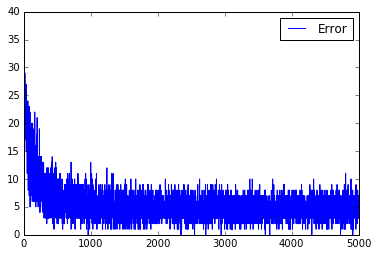

In [22]:
res = rbm2i.train_minibatch(input_s, 2, 5000, 10)
plot(res, label="Error")
legend()

In [23]:
# Let's look for learned parameters here
for i in xrange(0, rbm2i.feasize):
    hip = np.zeros(rbm2i.feasize)
    hip[i] = 1
    print "Features: %s" % hip
    _, vi = rbm2i.feed_b([hip])
#     print "Output: %s" % vi
    mv = ""
    for i in xrange(0, len(movies)): 
        if vi[0,i]!=0: 
            mv += " "+movies[i]
    print "Movies: %s" % mv

Features: [ 1.  0.  0.]
Movies:  Harry Potter Avatar LOTR
Features: [ 0.  1.  0.]
Movies:  LOTR Gladiator
Features: [ 0.  0.  1.]
Movies:  LOTR Gladiator Titanic


We can clearly see that the first and the last features are sci-fi and oscar winners. The middle one seems to be fantasy.

## MNIST Dataset
Now let's try using the MNIST dataset for training, much like we did with the perceptrons.

In [4]:
from mnist import MNIST
mndata = MNIST('mnist')
data = mndata.load_training()

In [5]:
training_images = data[0]
training_labels = data[1]

In [6]:
def out_process(digit):
    outv = np.zeros(10)
    outv[digit] = 1
    return outv
def in_process(inval):
    return inval/255.0

In [7]:
## Reshape and fit training data
selection_max = len(training_images)
def load_images(inp, selection_max, T=True):
    if(selection_max == -1): selection_max = len(inp)
    if(T):
        return in_process(np.matrix(inp[0:selection_max]).T)
    else:
        return in_process(np.matrix(inp[0:selection_max]).T)

training_data = load_images(training_images, selection_max)

In [8]:
## Reshape and fit labels
def load_labels(inp, selection_max):
    return numpy.apply_along_axis(func1d=out_process, arr=np.matrix(inp[0:selection_max]), axis=0)
training_data_l = load_labels(training_labels, selection_max)

In [9]:
def getbatch(training_set, training_set_l, batch_size=50):
    l, b = training_set.shape
    selection = np.random.randint(0,b, size=batch_size)
    return (training_set[:,np.array(selection)], training_set_l[:,np.array(selection)])
a, b = getbatch(training_data, training_data_l, 50)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.64it/s]


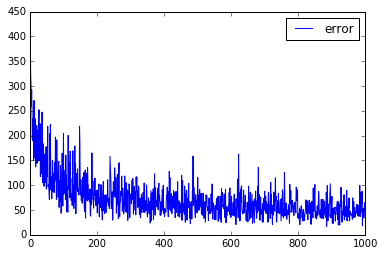

In [30]:
np.random.seed(1)
mnistrbm = rbm2(len(training_images[0]),100,0.1)
plot(mnistrbm.train(a.T, 2, 1000), label="error")
legend()

In [10]:
np.random.seed(1)
mnistrbm = rbm2(len(training_images[0]),64,1.)

Now let's try training on the entire dataset (hopefully it will finish soon):

In [10]:
res = []
inp = training_data[:,:].T

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [1:25:38<00:00,  1.97s/it]


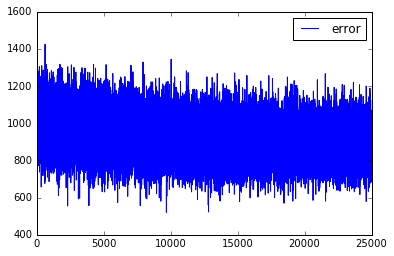

In [18]:
for i in tqdm(xrange(0, 2500)):
    res += mnistrbm.train_minibatch(inp, 5, 10, 10)
plot(res, label="error")
legend()

In [21]:
%%time
mnistrbm.save('mnistrbm.rbm')

Saving to mnistrbm.rbm
Saved.
Wall time: 64 ms


In [22]:
mnistrbm2 = rbm2.load('mnistrbm.rbm')

Now let's try developing level two of the DBM, reduce the output down to four units.

In [23]:
%%time
level2 = mnistrbm2.process(inp)

Wall time: 12.9 s


In [24]:
np.random.seed(1)
mnistrbm_l2 = rbm2(level2.shape[1],2,1.)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [29:14<00:00,  5.80it/s]


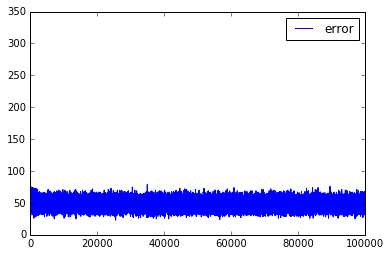

In [25]:
res2 = []
inpl2 = level2[:,:]
for i in tqdm(xrange(0, 10000)):
    res2 += mnistrbm_l2.train_minibatch(inpl2, 5, 10, 10)
plot(res2, label="error")
legend()

In [26]:
%%time
mnistrbm_l2.save('mnistrbml2.rbm')

Saving to mnistrbml2.rbm
Saved.
Wall time: 24 ms


Now let's try modifying the RBM to perform in proper CRBM operation using directions from geoffrey hinton's guide. The first thing is the input transformation - 

In [20]:
inp_gaussian = (inp-np.mean(inp))/np.std(inp)

The next thing is to modify the RBM so that there is a Linear Rectified Unit transformation at the hidden units.

In [21]:
def schmitt2(x):
        rand_val = np.random.rand(1)
        return np.max([0,(1 if rand_val <= x else 0)])

In [22]:
mnistcrbm = rbm2(len(training_images[0]), 64, 1.)
mnistcrbm.schmitt = np.vectorize(schmitt2)

100%|█| 1000/1000 [1:44:45<00:00,  6.15s/it]


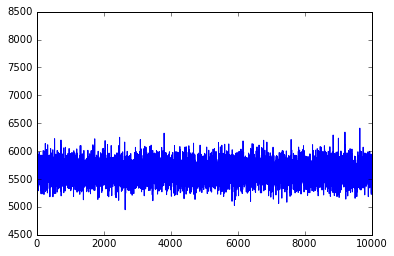

In [23]:
np.random.seed(1)
res = []
for i in tqdm(xrange(0, 1000)):
    res += mnistcrbm.train_minibatch(inp_gaussian, 5, 10, 10)
plot(res)